## RAG Agent

In [1]:
import json
import time
import torch
import os

from langchain_core.documents import Document
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate, AIMessagePromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph
from qdrant_client import QdrantClient
from qdrant_client.models import Filter, FieldCondition, MatchValue, Distance, VectorParams
from typing_extensions import List, TypedDict, Annotated, Literal

#---------------------------------------------------------------------------------------
# set parameters
#---------------------------------------------------------------------------------------
# general parameters
user_ID = "user_1" # user ID for the chat history

# Qdrant parameters
document_collection_name = "demo_collection" # name of the company documents Qdrant collection
product_collection_name = "product_collection" # name of the company documents Qdrant collection
history_collection_name = "history_collection" # name of the company documents Qdrant collection
db_path = "test_rag_db" # path to the Qdrant database
distance = Distance.COSINE # distance metric for the Qdrant database

# embedding model parameters
model_name = "sentence-transformers/all-mpnet-base-v2" # embedding model name

# LLM parameters
llm_name = "llama3.1:8b" # name of the LLM model
k = 5 # number of documents to retrieve from the RAG database
os.environ["TRANSFORMERS_NO_TF"] = "1"
#---------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------
# connect to Qdrant database and vector stores
#----------------------------------------------------------------------------------------
# embedding model used for the Qdrant database
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Initialize the Qdrant client with a local path
db_client = QdrantClient(path=db_path)

if not db_client.collection_exists(document_collection_name) or not db_client.collection_exists(product_collection_name):
    raise ValueError(f"Collection {document_collection_name} or {product_collection_name} does not exist.")

document_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=document_collection_name,
    embedding=embeddings,
)

product_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=product_collection_name,
    embedding=embeddings,
)

if not db_client.collection_exists(history_collection_name):
    # create history collection if it doesn't exist

    vector_length = len(embeddings.embed_documents(["dummy"])[0])  # get vector length from dummy embedding
    db_client.create_collection(
        collection_name=history_collection_name,
        vectors_config=VectorParams(size=vector_length, distance=distance),
    )

history_vector_store = QdrantVectorStore(
    client=db_client,
    collection_name=history_collection_name,
    embedding=embeddings,
)
#-----------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------
# set up promt + LLM and load companies + chat history
#---------------------------------------------------------------------------------------
# Load comanies 
with open("companies.json") as f:
    companies = json.load(f)

# Load chat history for the user
chat_history = db_client.scroll(
    collection_name=history_collection_name,
    scroll_filter=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))]),
    limit=1,
)
chat_history = chat_history[0][0].payload["chat_history"] if chat_history and len(chat_history[0]) > 0 else ""

# Define prompt for question-answering
system_message = SystemMessage("You are a helpful AI assistant for question-answering tasks. The provided chat history includes facts about the user you are speaking with.")
history_message = AIMessagePromptTemplate.from_template("Chat history: {chat_history}") 
input_message = HumanMessagePromptTemplate.from_template("""Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
                                                            Question: {question} Please provide a detailed answer to the question containing all the information provided in the context.
                                                            Context: {context} 
                                                            Answer:""") # create input message

prompt = ChatPromptTemplate.from_messages([system_message, history_message, input_message]) # create prompt template

# Define LLM for question-answering
device = ["cuda:0"] if torch.cuda.is_available() else ["cpu"]
print(f"Using device: {device}")
llm = ChatOllama(model=llm_name)


#-------------------------------------------------------------------------------------------
# Define state graph for the application
#---------------------------------------------------------------------------------------
# define Search query structure
class Search(TypedDict):

    query: Annotated[str, ..., "Search query to run."]
    company: Annotated[
        #Literal[tuple(companies.keys())],     # list of all companies in the database (add all companies here), ev also add topic filter
        Literal["Beiersdorf", "L'Oréal"],     # list of all companies in the database (add all companies here), ev also add topic filter
        ...,
        "company to query.",
    ]
    topic: Annotated[
        Literal["location,workforce,shareholders", "ethics", "environment"],     # list of topics
        ...,
        "topic the query is about.",
    ]

# Define state for application
class State(TypedDict):
    chat_history : str
    question: str
    query: Search
    context: List[Document]
    answer: str
    documet_db: QdrantVectorStore 
    product_db: QdrantVectorStore 
    history_db: QdrantVectorStore 
    client: QdrantClient 
    
# Define application steps
def analyze_query(state: State):
    """
    Extract the company and topic from the question and create a structured query.
    """

    structured_llm = llm.with_structured_output(Search)
    #TODO properly input the chat history and question
    query = structured_llm.invoke("chat history:\n" + state["chat_history"] + "\n\n" + "question:" + state["question"] + "\n\n" + "if there is conflicting information, use the information contained in the quesiton.")

    # map company info to location, workforce, shareholders (as this is how it is stored in the database but there is less ambiguity using the other term)
    if query["topic"] == "location,workforce,shareholders":
        query["topic"] = "company info"

    return {"query": query}

def retrieve(state: State):
    """
    Retrieve relevant documents from the document database based on the structured query.
    """
    query = state["query"]
    retrieved_docs = state["documet_db"].similarity_search(
        query["query"],
        filter=Filter(must=[FieldCondition(key="metadata.company", match=MatchValue(value=query["company"])),
                            FieldCondition(key="metadata.topic", match=MatchValue(value=query["topic"])),
                            ]),
        k=k,
    )
    return {"context": retrieved_docs}

def generate(state: State):
    """
    Generate an answer based on the retrieved documents, the chat history and the question.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], 
                              "context": docs_content,
                              "chat_history": state["chat_history"]})
    response = llm.invoke(messages)
    return {"answer": response.content}

def summarize(state: State):
    """
    Summarize the previous chat history, question, and answer into a new chat history.
    """
    summarization_prompt = ChatPromptTemplate.from_messages(
        [
            state["chat_history"],
            state["question"],
            state["answer"],
            (
                "user",
                "Distill the above chat messages into a single summary message. Include especially user preferences, company names and product names and if there is conflicting informatino save the most recent one.",
            ),
        ]
    )

    summary = llm.invoke(summarization_prompt.invoke({})).content
    return {"chat_history": summary}

def save_history(state: State):
    """
    Save the chat history to the history database (using the user_id).
    """
    state["client"].set_payload(
        collection_name=state["history_db"].collection_name,
        payload={"user_ID": user_ID, "chat_history": state["chat_history"]},
        points=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))]),
    )

# build and compile the state graph
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate, summarize, save_history])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
#---------------------------------------------------------------------------------------


# function to run the state graph with predefined database
def invoke_graph(graph: StateGraph, question: str, chat_history: str, 
                 db_client: QdrantClient = db_client, 
                 document_db: QdrantVectorStore = document_vector_store, 
                 product_db: QdrantVectorStore = product_vector_store, 
                 history_db: QdrantVectorStore = history_vector_store) -> str:
    """
    Run the state graph with the given question and chat history.

    Params:
        graph (StateGraph): The state graph to run.
        question (str): The question asked by the user.
        chat_history (str): The chat history for the user.
        Optional:
            db_client (QdrantClient): The Qdrant client to use.
            document_db (QdrantVectorStore): The document vector store to use.
            product_db (QdrantVectorStore): The product vector store to use.
            history_db (QdrantVectorStore): The history vector store to use.
    """
    state = State(
        chat_history=chat_history,
        question=question,
        query={},
        context=[],
        answer="",
        client=db_client,
        documet_db=document_db,
        product_db=product_db,
        history_db=history_db,
    )
    return graph.invoke(state)

Using device: ['cuda:0']


In [2]:
print(time.strftime("%H:%M:%S", time.localtime()))
result = invoke_graph(graph=graph,
                      question = "Can you tell me if Beiersdorf conducts animal testing?",
                      chat_history = chat_history)
chat_history = result["chat_history"] 

print(f'Metadata: {result["query"]["company"]}, {result["query"]["topic"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')

print(time.strftime("%H:%M:%S", time.localtime()))
print(f'\nAnswer LLM: {llm.invoke("Can you tell me if Beiersdorf conducts animal testing?").content}')
print(time.strftime("%H:%M:%S", time.localtime()))

11:01:41

Metadata: Beiersdorf, ethics
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'ethics', 'source_file': 'beiersdorf_ethics.json', '_id': 23, '_collection_name': 'demo_collection'}, page_content='certified cruelty-free brand by PETA or the Leaping Bunny program, as its compliance with Chinese regulations means some products may still be subject to animal testing in specific markets. However, the company is a member of the European Partnership for Alternative Approaches to Animal Testing (EPAA), reflecting its investment in non-animal research methods. **Labor Conditions:** Beiersdorf adheres to international labor standards and is a member of the United Nations Global Compact, committing to fair labor practices, human rights, and anti-corruption measures. The company’s 2022 Sustainability Report highlights initiatives to ensure safe working conditions, fair wages, and employee development programs across its supply chain. Independent audits, such as those by the S

In [108]:
db_client.close()

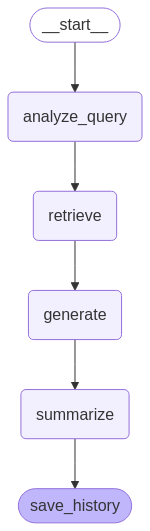

In [36]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

## Test conversation

In [2]:
result = invoke_graph(graph=graph,
                      question = "Can you tell me if Beiersdorf conducts animal testing?",
                      chat_history = chat_history)

print(f'previous chat_history: {chat_history}')

print(f'Metadata: {result["query"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')
chat_history = result["chat_history"]

previous chat_history: 
Metadata: {'query': 'Does Beiersdorf conduct animal testing?', 'company': 'Beiersdorf', 'topic': 'ethics'}
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'ethics', 'source_file': 'beiersdorf_ethics.json', '_id': 23, '_collection_name': 'demo_collection'}, page_content='certified cruelty-free brand by PETA or the Leaping Bunny program, as its compliance with Chinese regulations means some products may still be subject to animal testing in specific markets. However, the company is a member of the European Partnership for Alternative Approaches to Animal Testing (EPAA), reflecting its investment in non-animal research methods. **Labor Conditions:** Beiersdorf adheres to international labor standards and is a member of the United Nations Global Compact, committing to fair labor practices, human rights, and anti-corruption measures. The company’s 2022 Sustainability Report highlights initiatives to ensure safe working conditions, fair wages, and emplo

In [3]:
result = invoke_graph(graph=graph,
                      question = "Can you tell me about any of the companies environmental policies?",
                      chat_history = chat_history)

print(f'previous chat_history: {chat_history}')

print(f'Metadata: {result["query"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')
chat_history = result["chat_history"]

previous chat_history: Here's a summary of the information:

Beiersdorf conducts animal testing only where required by law, including in China where regulatory authorities may require it for certain products. Despite this, the company is committed to alternative testing methods through its membership in EPAA and has reduced its reliance on animal testing.

**No specific user preference or product name mentioned**

Let me know if you'd like any further clarification!
Metadata: {'query': 'Is Beiersdorf committed to environmental policies?', 'company': 'Beiersdorf', 'topic': 'environment'}
Context: [Document(metadata={'company': 'Beiersdorf', 'topic': 'environment', 'source_file': 'beiersdorf_env.json', '_id': 18, '_collection_name': 'demo_collection'}, page_content="Beiersdorf, the German multinational company behind brands like Nivea, Eucerin, and La Prairie, has made significant commitments to environmental sustainability, which are outlined in its official reports and verified by inde

In [4]:
result = invoke_graph(graph=graph,
                      question = "Can you tell me about Loreals animal testing policies?",
                      chat_history = chat_history)

print(f'previous chat_history: {chat_history}')

print(f'Metadata: {result["query"]}')
print(f'Context: {result["context"]}\n\n')
print(f'Answer RAG: {result["answer"]}\n\n')
print(f'Chat history: {result["chat_history"]}')
chat_history = result["chat_history"]

previous chat_history: Here's a summary of the conversation:

Beiersdorf, the parent company of Nivea, conducts animal testing only where required by law, including in China. However, it is committed to alternative testing methods through its membership in EPAA and has reduced its reliance on animal testing.

Regarding Beiersdorf's environmental policies, the company has made significant commitments to sustainability through its "Care Beyond Skin" strategy. This includes:

* Climate Action: reducing greenhouse gas emissions by 30% by 2025 and achieving net-zero emissions by 2045
* Sustainable Packaging: aiming for 100% of packaging to be reusable, recyclable, or compostable by 2025 (89% currently meet this criteria)
* Responsible Sourcing: adhering to strict sourcing guidelines for raw materials, including RSPO-certified palm oil derivatives and fair trade partnerships for organic shea butter
* Water Stewardship: reducing water consumption in production processes by 35% since 2014 and 

### Clear chat history

In [18]:
db_client.delete(collection_name=history_collection_name, points_selector=Filter(must=[FieldCondition(key="user_ID", match=MatchValue(value=user_ID))])) # delete user chat history from database
db_client.close() # close the database connection